# An in-depth analysis on the use of long short-term memory networks to predict incidence and prevalence of Covid-19 in Latin America

Upload manually the datasets

In [ ]:
import pandas as pd
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Flatten
from keras.optimizers import Adam
import tensorflow as tf
from time import time
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model

from sklearn import metrics
from sklearn import preprocessing
from sklearn.preprocessing import scale
from sklearn.metrics import *
from itertools import product
import seaborn as sns
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
sns.set(font='IPAGothic')
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
sns.set()

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Read CSVs

In [ ]:
argentina = pd.read_csv('argentina.csv', sep=',', index_col='date', parse_dates=True)
bolivia = pd.read_csv('bolivia.csv', sep=',', index_col='date', parse_dates=True)
brazil = pd.read_csv('brazil.csv', sep=',', index_col='date', parse_dates=True)
chile = pd.read_csv('chile.csv', sep=',', index_col='date', parse_dates=True)
colombia = pd.read_csv('colombia.csv', sep=',', index_col='date', parse_dates=True)
cuba = pd.read_csv('cuba.csv', sep=',', index_col='date', parse_dates=True)
ecuador = pd.read_csv('ecuador.csv', sep=',', index_col='date', parse_dates=True)
guatemala = pd.read_csv('guatemala.csv', sep=',', index_col='date', parse_dates=True)
haiti = pd.read_csv('haiti.csv', sep=',', index_col='date', parse_dates=True)
mexico = pd.read_csv('mexico.csv', sep=',', index_col='date', parse_dates=True)
peru = pd.read_csv('peru.csv', sep=',', index_col='date', parse_dates=True)
venezuela = pd.read_csv('venezuela.csv', sep=',', index_col='date', parse_dates=True)

## Create GridSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV

def finder(X_train, y_train, model, params, cross_v):

    finder = GridSearchCV(
            estimator=model,
            param_grid=params,
            scoring='neg_mean_absolute_error',
            n_jobs=-1,
            iid=False,
            refit=False,
            cv=cross_v,
            verbose=1,
            pre_dispatch=8,
            error_score=-999,
            return_train_score=True
        )

    finder.fit(X_train, y_train)

    
    return finder.best_params_, finder.cv_results_


## Create Blocking Time Series Split

In [ ]:
class BlockingTimeSeriesSplit():
    def __init__(self, n_splits):
        self.n_splits = n_splits
    
    def get_n_splits(self, X, y, groups):
        return self.n_splits
    
    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)

        margin = 0
        for i in range(self.n_splits):
            start = i * k_fold_size
            stop = start + k_fold_size
            mid = int(0.8 * (stop - start)) + start
            yield indices[start: mid], indices[mid + margin: stop]

## SVR Implementation

In [ ]:
def train_svr(tra_cross, trv, tra_cross_target, trv_target): 
    
    param_grid = {'kernel': ['linear', 'rbf', 'sigmoid', 'poly'],
                  'C': [0.01, 0.1, 1, 5, 10, 20, 50],
                  'epsilon': [0.001, 0.01, 0.1]}

    clf = SVR()
    tscv = TimeSeriesSplit(n_splits=5)
    bscv = BlockingTimeSeriesSplit(n_splits=5)

    best_params, cv_results = finder(tra_cross, tra_cross_target, clf, param_grid, bscv)
    
    clf_train = SVR(**best_params)

    clf_train.fit(tra_cross, tra_cross_target)
    pred = pd.DataFrame(clf_train.predict(trv))

    pred.columns = ['previsao']
    pred['date'] = trv_target.index
    
    pred = pred.set_index('date')

    mae_test_svr  = mean_absolute_error(trv_target, pred)
    
    return mae_test_svr, pred, trv_target, best_params, cv_results

## Create the inputs for the LSTM

In [ ]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    data.append(dataset[indices])
  
  return np.array(data), np.array(labels)

##LSTM Implementation - TensorFlow 2.0

In [ ]:
def train_lstm_multivariate(multi_cross, multi_teste, target_cross, target_teste, target, grid_val_metrics_lstm, country): 
    
    batch_sizes = [2, 4, 8, 16, 32]
    neuron_numbers = [10, 50, 100, 200, 500]
    past_histories = [2, 5, 10, 20]
    n_epochs = [20, 50, 100, 200, 500]
    univariate_future_target = 1
    mean_mae_lstm_sum = 0
    mae_ant_lstm = 0
    mae_lstm = 0
    median_mae = 0
    loss_metric = 'mae'
    pred_ant = 0
    pred_ant_lstm = 0
    first_time = 0
    first_time_lstm = 0
    best_parameters = []
    best_parameters_lstm = []
  
    mean_mae_lstm = pd.DataFrame(columns = ['mae_lstm', 'batch_size', 'neuron_number', 'n_epoch', 'target', 'country'])


    btscv = BlockingTimeSeriesSplit(n_splits=5)

      
    for batch_size in batch_sizes:
        for neuron_number in neuron_numbers:
            print("treino - "+all_countries[i_country]+" - neurons: "+str(neuron_number)+" - batch_size: "+str(batch_size))          
            for past_history in past_histories:
                for n_epoch in n_epochs:
                     for train_index, test_index in btscv.split(multi_cross):
                
                        X_train, X_val = multi_cross.loc[train_index], multi_cross.loc[test_index]
                        Y_train, Y_val = target_cross.loc[train_index], target_cross.loc[test_index]
                 
                                    
                        scaler = StandardScaler()
                        scaler.fit(X_train)
                        multi_data_slice = scaler.transform(X_train)
                        multi_data_slice_val = scaler.transform(X_val)
                        
                        scaler_2 = StandardScaler()
                        scaler_2.fit(Y_train)
                        target_multi_slice = scaler_2.transform(Y_train)
                        target_multi_slice_val = scaler_2.transform(Y_val)

                        x_train_uni = univariate_data_x(multi_data_slice, 0, len(multi_data_slice),
                                                              past_history,
                                                              1)
                        x_val_uni = univariate_data_x(multi_data_slice_val, 0, len(multi_data_slice_val),
                                                              past_history,
                                                              1)
                        
                        y_train_uni = univariate_data_y(target_multi_slice, 0, len(target_multi_slice),
                                                              past_history,
                                                              1)
                        
                        
                        y_val_uni = univariate_data_y(target_multi_slice_val, 0, len(target_multi_slice_val),
                                                              past_history,
                                                              1)
                        
                        model = Sequential()
                        model.add(LSTM(units=neuron_number,input_shape=(x_train_uni.shape[1],6),return_sequences=True))
                        model.add(Flatten())
                        model.add(Dense(1))
                        
                        ADAM=tf.keras.optimizers.Adam(0.0005, beta_1=0.9, beta_2=0.999, amsgrad=False)
                        model.compile(loss=loss_metric, optimizer=ADAM)
                        history = model.fit(x_train_uni, y_train_uni,
                                            epochs=n_epoch,
                                            batch_size=batch_size,
                                            validation_data=(x_val_uni, y_val_uni),
                                            verbose=0,
                                            shuffle=False)
                                           
                        grid_val_metrics_lstm = grid_val_metrics_lstm.append({"country": country, 'target': target,  "batch_size":  batch_size, "neuron_number": neuron_number, "past_history": past_history, "n_epoch": n_epoch, "val_score": history.history['val_loss'][-1]}, ignore_index=True)
                   
                        mae_lstm = mean_absolute_error(scaler_2.inverse_transform(y_val_uni), scaler_2.inverse_transform(model.predict(x_val_uni)))

                        mean_mae_lstm_sum += mae_lstm
         
                        tf.keras.backend.clear_session()

                     div_mae_sum = mean_mae_lstm_sum/5
                      
                     
                     mean_mae_lstm = mean_mae_lstm.append({'mae_lstm': div_mae_sum, "batch_size":  batch_size, "neuron_number": neuron_number, "n_epoch": n_epoch, 'target': target, 'country': country}, ignore_index=True)
                     if first_time_lstm==0:
                         mae_ant_lstm = div_mae_sum
                         first_time_lstm = 1
                         best_parameters_lstm = [batch_size, neuron_number, past_history, n_epoch]
                     elif div_mae_sum < mae_ant_lstm:
                         best_parameters_lstm = [batch_size, neuron_number, past_history, n_epoch]
                         mae_ant_lstm = mae_lstm

                     mean_mae_lstm_sum = 0       

    slice_uni = 3+best_parameters_lstm[2]

    print("Test begins")
    scaler_3 = StandardScaler()
    scaler_3.fit(multi_cross)
    multi_data_slice = scaler_3.transform(multi_cross)
    multi_data_slice_test = scaler_3.transform(multi_teste)


    scaler_4 = StandardScaler()
    scaler_4.fit(target_cross)
    target_multi_slice = scaler_4.transform(target_cross)
    target_multi_slice_test = scaler_4.transform(target_teste)


    x_train_uni = univariate_data_x(multi_data_slice, 0, len(multi_data_slice),
                                          past_history,
                                          1)
    x_test_uni = univariate_data_x(multi_data_slice_test, 0, len(multi_data_slice_test),
                                          past_history,
                                          1)
    
    y_train_uni = univariate_data_y(target_multi_slice, 0, len(target_multi_slice),
                                          past_history,
                                          1)
        
    y_test_uni = univariate_data_y(target_multi_slice_test, 0, len(target_multi_slice_test),
                                          past_history,
                                          1)
    
    model = Sequential()
    model.add(LSTM(units=best_parameters_lstm[1],input_shape=(x_train_uni.shape[1],6),return_sequences=True))
    model.add(Flatten())
    model.add(Dense(1))
    ADAM=tf.keras.optimizers.Adam(0.0005, beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(loss='mae', optimizer=ADAM)

    history = model.fit(x_train_uni, y_train_uni,
                        epochs=n_epoch,
                        batch_size=best_parameters_lstm[0],
                        validation_data=(x_test_uni, y_test_uni),
                        verbose=0,
                        shuffle=False)

    print("Test is finished")
    print(all_countries[i_country]+" - "+target)
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.title(all_countries[i_country]+" - neuron: "+str(neuron_number)+" - batch: "+str(batch_size))
    plt.legend()
    plt.show()
    
    pred_lstm = scaler_4.inverse_transform(model.predict(x_test_uni))
    mae_lstm_test = mean_absolute_error(scaler_4.inverse_transform(y_test_uni), pred_lstm)
    
    
    return mae_ant_lstm, mae_lstm_test, pred_lstm, best_parameters_lstm, scaler_4.inverse_transform(y_test_uni), grid_val_metrics_lstm, mean_mae_lstm

## Formating exogenous variables

In [ ]:
def format_exogenous(dataset_country, target):

    if target == 'prevalence':
        dataset_country['totalcases'] = dataset_country['totalcases'].shift(1, axis = 0)
        dataset_country['newcases'] = dataset_country['newcases'].shift(1, axis = 0)
        dataset_country['incidence'] = dataset_country['incidence'].shift(1, axis = 0)
        dataset_country['incidence7d'] = dataset_country['incidence7d'].shift(1, axis = 0)
        dataset_country['deathrate'] = dataset_country['deathrate'].shift(1, axis = 0)
    elif target == 'deathrate':
        dataset_country['newcases'] = dataset_country['newcases'].shift(1, axis = 0)
        dataset_country['totalcases'] = dataset_country['totalcases'].shift(1, axis = 0)
        dataset_country['prevalence'] = dataset_country['prevalence'].shift(1, axis = 0)
        dataset_country['incidence'] = dataset_country['incidence'].shift(1, axis = 0)
        dataset_country['incidence7d'] = dataset_country['incidence7d'].shift(1, axis = 0)
    else:
        dataset_country['newcases'] = dataset_country['newcases'].shift(1, axis = 0)
        dataset_country['totalcases'] = dataset_country['totalcases'].shift(1, axis = 0)
        dataset_country['prevalence'] = dataset_country['prevalence'].shift(1, axis = 0)
        dataset_country['incidence7d'] = dataset_country['incidence7d'].shift(1, axis = 0)
        dataset_country['deathrate'] = dataset_country['deathrate'].shift(1, axis = 0)
        

    dataset_country = dataset_country.dropna()

    return dataset_country

## Selecting which countries to evaluate (datasets) and training

treino - argentina - neurons: 10 - batch_size: 2
começou o teste
acabou o teste
argentina - incidence


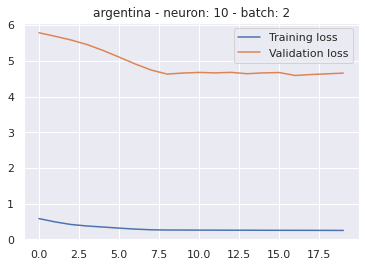

País argentina
Target incidence
treino - argentina - neurons: 10 - batch_size: 2
começou o teste
acabou o teste
argentina - prevalence


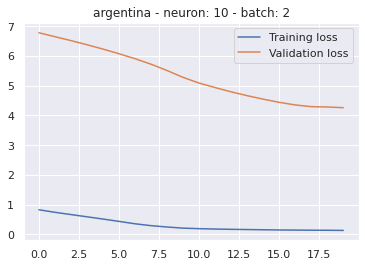

País argentina
Target prevalence


In [ ]:
all_dataset_countries = [argentina, bolivia, brazil, colombia, cuba, guatemala, haiti, mexico, peru]
all_countries = ['argentina', 'bolivia', 'brazil', 'colombia', 'cuba', 'guatemala', 'haiti', 'mexico', 'peru']
all_models = ['lstm', 'svr']
all_targets = ['incidence', 'prevalence']
i_country = 0
grid_test_metrics = pd.DataFrame(columns = ['model', 'target', 'MAE_model', 'country', 'parameters'])
grid_predictions = pd.DataFrame(columns = ['model', 'target', 'prediction', 'country', 'parameters', 'real_value'])
grid_val_metrics_svr = pd.DataFrame(columns = ['country', 'target', 'param_C', 'param_epsilon', 'param_kernel', 'mean_test_score', 'rank_test_score'])
grid_val_metrics_lstm = pd.DataFrame(columns = ['country', 'target', 'batch_size', 'neuron_number', 'past_history', 'n_epoch', 'val_score'])
mean_mae_lstm_all_countries = pd.DataFrame(columns = ['mae_lstm', 'batch_size', 'neuron_number', 'n_epoch', 'target', 'country'])



for dataset_country in all_dataset_countries:
    for target in all_targets:
        for model in all_models:

            if  model in ('svr'):
                
                dataset_country = format_exogenous(dataset_country, target)
                
                tra_cross, trv = train_test_split(pd.DataFrame(dataset_country.dropna()), test_size=0.2, shuffle=False)
            
                
                tra_cross_target = tra_cross.pop(target)
                trv_target       = trv.pop(target)

                mae_test_sarimax, pred_svr, real_value, best_params, cv_results = train_svr(tra_cross, trv, tra_cross_target, trv_target)
                
                real_value_previsao = pd.concat([real_value, pred_svr], axis=1)
                
                cv_results = pd.DataFrame(cv_results)
                for i, row in cv_results.iterrows():
                    grid_val_metrics_svr = grid_val_metrics_svr.append({'country': all_countries[i_country], 'target': target, 'param_C': row['param_C'], 'param_epsilon': row['param_epsilon'], 'param_kernel': row['param_kernel'], 'mean_test_score': row['mean_test_score'], 'rank_test_score': row['rank_test_score']}, ignore_index=True)
                
                grid_test_metrics = grid_test_metrics.append({"model": 'svr', 'target': target, "MAE_model":  mae_test_sarimax, "country": all_countries[i_country], "parameters": str(best_params)}, ignore_index=True)

                for i, row in real_value_previsao.iterrows():
                    grid_predictions = grid_predictions.append({"model": 'svr', 'target': target,  "prediction":  row['previsao'], "country": all_countries[i_country], "parameters": str(best_params), "real_value": row[target]}, ignore_index=True)
                
           
            if model in ('lstm'):
                
                uni_data = dataset_country[target]
                uni_data.index = dataset_country.index
                uni_data = uni_data.values
             
                multi_exog = format_exogenous(dataset_country, target)
                multi_target = np.array(multi_exog.pop(target))
                multi_exog = np.array(multi_exog)

                multi_cross, multi_teste = train_test_split(pd.DataFrame(multi_exog), test_size=0.2, shuffle=False)
                target_cross, target_teste = train_test_split(pd.DataFrame(multi_target), test_size=0.2, shuffle=False)
            

                mae_ant_lstm, mae_lstm_test, pred_lstm, best_parameters_lstm, real_value, grid_val_metrics_lstm, mean_mae_lstm = train_lstm_multivariate(multi_cross, multi_teste, target_cross, target_teste, target, grid_val_metrics_lstm, all_countries[i_country])

                mean_mae_lstm_all_countries = pd.concat([mean_mae_lstm_all_countries, mean_mae_lstm], ignore_index=True)

                real_value = pd.DataFrame(data=real_value,
                                          columns=["real_value"])  
                previsao = pd.DataFrame(data=pred_lstm,
                                        columns=["previsao"])  
                real_value_previsao = pd.concat([real_value, previsao], axis=1)

                grid_test_metrics = grid_test_metrics.append({"model": 'lstm_multivariate', 'target': target, "MAE_model":  mae_lstm_test, "country": all_countries[i_country], "parameters": str(best_parameters_lstm)}, ignore_index=True)

                for i, row in real_value_previsao.iterrows():
                    grid_predictions = grid_predictions.append({"model": 'lstm_multivariate', 'target': target,  "prediction":  row['previsao'], "country": all_countries[i_country], "parameters": str(best_parameters_lstm), "real_value": row['real_value']}, ignore_index=True)
                

                print("País", all_countries[i_country])
                print("Target", target)



    if len(all_countries) != 0:
        i_country = i_country+1

mean_mae_lstm_all_countries.to_csv('mean_mae_lstm_all_countries.csv')

## Saving metrics on CSVs

In [ ]:
grid_val_metrics_svr.to_csv('grid_val_metrics_svr.csv')
!cp grid_val_metrics_svr.csv "drive/My Drive/"

grid_test_metrics.to_csv('grid_test_metrics_svr.csv')
!cp grid_test_metrics_svr.csv "drive/My Drive/"


In [ ]:
grid_test_metrics.to_csv('grid_test_metrics_lstm_inc_1.csv')
!cp grid_test_metrics_lstm_inc_1.csv "drive/My Drive/"

mean_mae_lstm_all_countries.to_csv('grid_val_metrics_lstm_inc_1.csv')
!cp grid_val_metrics_lstm_inc_1.csv "drive/My Drive/"

grid_val_metrics_lstm.to_csv('grid_val_metrics_blocks_lstm_inc_1.csv')
!cp grid_val_metrics_blocks_lstm_inc_1.csv "drive/My Drive/"